Link to Google nontebook: https://colab.research.google.com/drive/1t_EsQa760y9B6qRsf1foFTiwAzls0gDE

In [ ]:
pip install -i https://test.pypi.org/simple/ icalgosocdemo==0.0.10

Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 675kB 2.9MB/s 


In [ ]:
from icalgodemo.strategy import Strategy
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Week 4 VIX as a trading signal for SPY

In [ ]:
class BuyandHoldStrategy(Strategy):

    def before_trades(self):
      self.counter = 0
      return None 
    
    def ondata(self,bid,ask):
      self.counter += 1
      if self.counter>=200:
        return 1
      else:
        return 0


In [ ]:
strat = BuyandHoldStrategy(datasets='SPY')
strat.train()

Running Pedlar Demo for single asset. Dataset SPY


In [ ]:
strat.download_train(dataset='VIX')
strat.download_train(dataset='SPY')

Training Data Downloaded from dataset VIX
Training Data Downloaded from dataset SPY


In [ ]:
SPY = pd.read_csv('Train_SPY.csv',index_col=0)
VIX = pd.read_csv('Train_VIX.csv',index_col=0)

In [ ]:
Merged = SPY.merge(VIX,on='Time',suffixes=('_SPY','_VIX'))
Merged['Mid_SPY'] = (Merged['Ask_SPY'] + Merged['Bid_SPY'])/2
Merged['Mid_VIX'] = (Merged['Ask_VIX'] + Merged['Bid_VIX'])/2
Merged['Return_SPY'] = np.log(Merged['Mid_SPY']) - np.log(Merged['Mid_SPY'].shift(1)) 
Merged['Return_VIX'] = np.log(Merged['Mid_VIX']) - np.log(Merged['Mid_VIX'].shift(1)) 
Merged.dropna(inplace=True)

In [ ]:
Merged.head()

,Time,Bid_SPY,Ask_SPY,Bid_VIX,Ask_VIX,Mid_SPY,Mid_VIX,Return_SPY,Return_VIX
1,2005-02-28,100.675,100.685,11.73,12.50,100.68,12.115,-0.006731,0.065227
2,2005-03-01,101.195,101.205,11.66,12.10,101.20,11.880,0.005152,-0.019588
3,2005-03-02,101.145,101.155,12.20,12.91,101.15,12.555,-0.000494,0.055263
4,2005-03-03,101.185,101.195,12.23,13.07,101.19,12.650,0.000395,0.007538
5,2005-03-04,102.465,102.475,11.94,12.50,102.47,12.220,0.012570,-0.034583


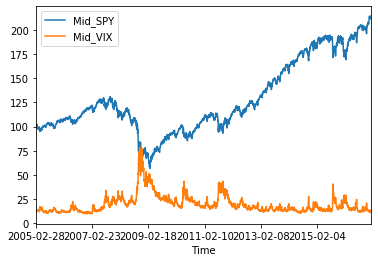

In [ ]:
Merged.plot(x='Time',y=['Mid_SPY','Mid_VIX'])

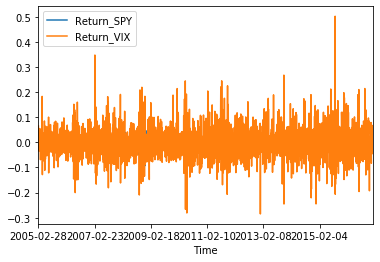

In [ ]:
Merged.plot(x='Time',y=['Return_SPY','Return_VIX'])

In [ ]:
np.corrcoef(Merged['Return_SPY'],Merged['Return_VIX'])

array([[ 1.        , -0.56583049],
       [-0.56583049,  1.        ]])

Log return for SPY and VIX are negatively correlated

### Using SPY and VIX to predict direction of SPY for the next day

In [ ]:
Merged['Target'] = np.sign(Merged['Return_SPY'].shift(-1))
Merged.dropna(inplace=True)

In [ ]:
Merged.head(5)

,Time,Bid_SPY,Ask_SPY,Bid_VIX,Ask_VIX,Mid_SPY,Mid_VIX,Return_SPY,Return_VIX,Target
1,2005-02-28,100.675,100.685,11.73,12.50,100.68,12.115,-0.006731,0.065227,1.0
2,2005-03-01,101.195,101.205,11.66,12.10,101.20,11.880,0.005152,-0.019588,-1.0
3,2005-03-02,101.145,101.155,12.20,12.91,101.15,12.555,-0.000494,0.055263,1.0
4,2005-03-03,101.185,101.195,12.23,13.07,101.19,12.650,0.000395,0.007538,1.0
5,2005-03-04,102.465,102.475,11.94,12.50,102.47,12.220,0.012570,-0.034583,1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf = RandomForestClassifier(max_depth=12, random_state=0,max_features=None)
X = Merged[['Return_SPY','Return_VIX']]
y = Merged['Target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=0,shuffle=False)
clf.fit(X_train, y_train)
print('In sample: {}'.format(clf.score(X_train, y_train)))
print('Out of sample: {}'.format(clf.score(X_test, y_test)))

In sample: 0.8526119402985075
Out of sample: 0.5234899328859061


Question: A 52% accuracy is achieved. How would you build a trading strategy on SPY using VIX as a signal? 

In [ ]:
expected_return = X_test['Return_SPY'].shift(-1) * clf.predict(X_test)

Text(0.5, 1.0, 'Cumulative log Return')

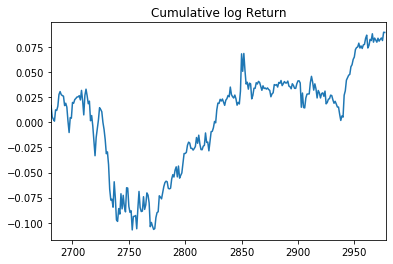

In [ ]:
np.cumsum(expected_return).plot()
plt.title('Cumulative log Return')

Question: Using the VIX signal from Random Forest directly does not give a good strategy. How would you improve the strategy using techniques from previous lectures?